# Facial Keypoints - Model Training

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

In [2]:
#   Get the Data Loaders ..

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from facepoint.data_load import FacialKeypointsDataset
from facepoint.data_load import Rescale, RandomCrop, Normalize, ToTensor

BATCH_SIZE = 32


data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

# load training data

from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(range(2770)) # about 80% of the training images 
validation_sampler = SubsetRandomSampler(range(2771,len(transformed_dataset)))

train_loader = DataLoader(transformed_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          sampler=train_sampler)

# Create a Validation Set. ( It seems that we can't use data/test for validation as they are copies from the training data)
validation_loader = DataLoader(transformed_dataset, 
                               batch_size=batch_size,
                               num_workers=0,
                               sampler=validation_sampler)


# Load Test set
# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)


# load test data in batches

test_loader = DataLoader(test_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=True, 
                          num_workers=0)


In [18]:
# Get the Model

from facepoint.models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 24, kernel_size=(2, 2), stride=(1, 1))
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3456, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=136, bias=True)
)


In [ ]:
# Train the Model

import torch.optim as optim
import torch.nn as nn
from facepoint.model_trainer import ModelTrainer

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

trainer = ModelTrainer(net, optimizer, criterion, train_loader, validation_loader)
trainer.init_weights()
trainer.train(2)

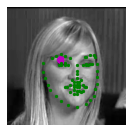

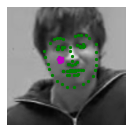

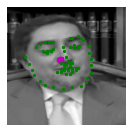

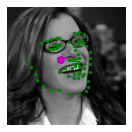

In [26]:
# Test on some sample data
from facepoint.utils import visualize_output, net_sample_output

test_images, test_outputs, gt_pts = net_sample_output(test_loader, net)
visualize_output(test_images, test_outputs, gt_pts, 4)

In [27]:
# Save model
trainer.save_model()